# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
unity_env = UnityEnvironment(file_name="env/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = unity_env.brain_names[0]
brain = unity_env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = unity_env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = unity_env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = unity_env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [ ]:
unity_env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# Deep Q-Network implementation

As we saw previously in [section 2](#2.-Examine-the-State-and-Action-Spaces) what we're dealing with here is an envirornment with continuous state space and discrete action space with 4 possible actions. Deep Q-Network is an excellent choise to address this problem.

I'm gonna try to solve this environment using vanilla [Deep Q-Netwok](http://www.readcube.com/articles/10.1038/nature14236) and different improvements such as:
1. [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)
2. [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)
3. [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)
4. [Noisy Networks for Exploration](https://arxiv.org/abs/1706.10295)

In [4]:
from agent.agent import DQNAgent
from agent.utils import EnvironmentAdapterForUnity, plot_scores, run_env

The following is a wrapper I've implemented since I'm using the same agent I used in LunarLander exercise which was running against an [OpenAI Gym environment](https://gym.openai.com/envs/LunarLander-v2/). This environment differs a bit from the Unity environment API so I created this adapter as a proxy. 

In [5]:
env = EnvironmentAdapterForUnity(unity_env, brain_name)

### 1. Vanilla Deep Q-Network agent

In [7]:
agent = DQNAgent(env.state_size, env.action_size)
agent.summary()

DQNAgent:

Using Double: False
Using Dueling: False
Using Priority: False
Using Noise: False

QNetwork(
  (fc1): Linear(in_features=37, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


In [8]:
scores = agent.train(env)

Episode 100	Average Score: 0.50
* Best score so far: 0.5. Saving the weights

Episode 200	Average Score: 3.20
* Best score so far: 3.2. Saving the weights

Episode 300	Average Score: 7.46
* Best score so far: 7.46. Saving the weights

Episode 400	Average Score: 9.32
* Best score so far: 9.32. Saving the weights

Episode 500	Average Score: 11.66
* Best score so far: 11.66. Saving the weights

Episode 600	Average Score: 14.24
* Best score so far: 14.24. Saving the weights

Episode 700	Average Score: 14.64
* Best score so far: 14.64. Saving the weights

Episode 800	Average Score: 15.01
* Best score so far: 15.01. Saving the weights

Episode 900	Average Score: 15.12
* Best score so far: 15.12. Saving the weights

Episode 1000	Average Score: 15.75
* Best score so far: 15.75. Saving the weights



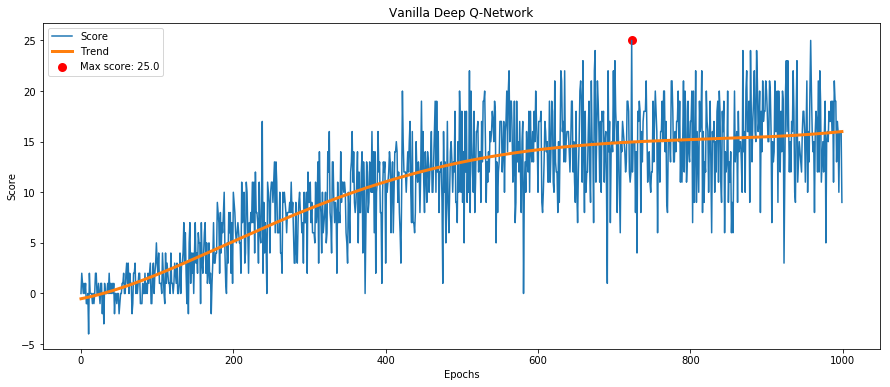

In [9]:
plot_scores(scores, 'Vanilla Deep Q-Network', polyfit_deg=6)

In [7]:
# agent.load_weights('local_weights.pth')

### 2. DQN using Double Q-Network

Double DQNs, or double Learning, was introduced by [Hado van Hasselt](https://papers.nips.cc/paper/3964-double-q-learning). This method handles the problem of the overestimation of Q-values. 

There is an interesting [article](https://towardsdatascience.com/double-deep-q-networks-905dd8325412) explaining this solution.

In [7]:
agent = DQNAgent(env.state_size, env.action_size, use_double=True)
agent.summary()

DQNAgent:

Using Double: True
Using Dueling: False
Using Priority: False
Using Noise: False

QNetwork(
  (fc1): Linear(in_features=37, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


In [8]:
scores = agent.train(env)

Episode 100	Average Score: 0.90
* Best score so far: 0.9. Saving the weights

Episode 200	Average Score: 4.12
* Best score so far: 4.12. Saving the weights

Episode 300	Average Score: 7.77
* Best score so far: 7.77. Saving the weights

Episode 400	Average Score: 10.23
* Best score so far: 10.23. Saving the weights

Episode 500	Average Score: 12.99
* Best score so far: 12.99. Saving the weights

Episode 600	Average Score: 13.89
* Best score so far: 13.89. Saving the weights

Episode 700	Average Score: 14.86
* Best score so far: 14.86. Saving the weights

Episode 800	Average Score: 15.58
* Best score so far: 15.58. Saving the weights

Episode 900	Average Score: 15.84
* Best score so far: 15.84. Saving the weights

Episode 1000	Average Score: 16.03
* Best score so far: 16.03. Saving the weights



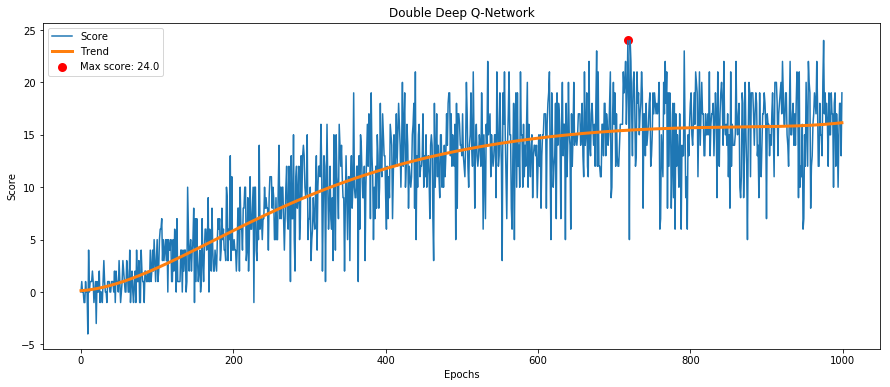

In [9]:
plot_scores(scores, 'Double Deep Q-Network', polyfit_deg=6)

In [ ]:
# agent.load_weights('double_local_weights.pth')

### 3. DQN using Dueling Network architecture

The Q-values correspond to how good it is to be at that state and taking an action at that state Q(s,a). The idea behind this architecture is to separate the estimator of two elements:
- V(s): the value of being at that state
- A(s,a): the advantage of taking that action at that state (how much better is to take this action versus all other possible actions at that state).

using two new streams, and then we combine them through a special aggregation layer to get an estimate of Q(s,a).

[Here](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df#af34) there is better explanation of the architecture.

In [7]:
agent = DQNAgent(env.state_size, env.action_size, use_dueling=True)
agent.summary()

DQNAgent:

Using Double: False
Using Dueling: True
Using Priority: False
Using Noise: False

DuelingQNetwork(
  (features): Sequential(
    (0): Linear(in_features=37, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
  )
  (advantage): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [8]:
scores = agent.train(env)

Episode 100	Average Score: 0.61
* Best score so far: 0.61. Saving the weights

Episode 200	Average Score: 4.14
* Best score so far: 4.14. Saving the weights

Episode 300	Average Score: 7.32
* Best score so far: 7.32. Saving the weights

Episode 400	Average Score: 10.06
* Best score so far: 10.06. Saving the weights

Episode 500	Average Score: 13.06
* Best score so far: 13.06. Saving the weights

Episode 600	Average Score: 14.49
* Best score so far: 14.49. Saving the weights

Episode 700	Average Score: 15.28
* Best score so far: 15.28. Saving the weights

Episode 800	Average Score: 15.74
* Best score so far: 15.74. Saving the weights

Episode 900	Average Score: 14.41
Episode 1000	Average Score: 13.96


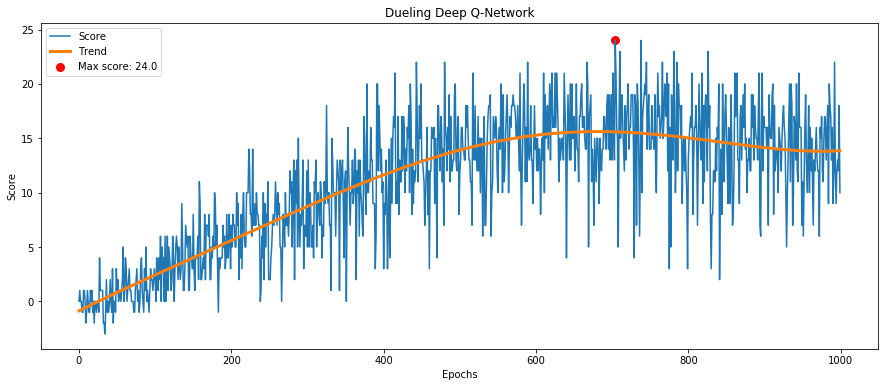

In [9]:
plot_scores(scores, 'Dueling Deep Q-Network', polyfit_deg=6)

### 4. DQN using Prioritized Experience Replay

Prioritized Experience Replay (PER) was introduced in 2015 by [Tom Schaul](https://arxiv.org/search/?searchtype=author&query=Schaul%2C+T). In the famous DQN algorithm, a buffer of past experiences is used to stabilize training by decorrelating the training examples in each batch used to update the neural network. But some experiences may be more important than others for our training, and might occur less frequently. Because we sample the batch uniformly (selecting the experiences randomly) these rich experiences that occur rarely have practically no chance to be selected. with PER we try to change the sampling distribution by using a criterion to define the priority of each tuple of experience.

You can find more details about experience replay and PER in this [article](https://medium.com/@badamivikas/deeper-intuition-on-prioritized-experience-replay-33fcc55de44e)

In [7]:
agent = DQNAgent(env.state_size, env.action_size, use_priority=True)
agent.summary()

DQNAgent:

Using Double: False
Using Dueling: False
Using Priority: True
Using Noise: False

QNetwork(
  (fc1): Linear(in_features=37, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


In [8]:
scores = agent.train(env)

Episode 100	Average Score: 1.19
* Best score so far: 1.19. Saving the weights

Episode 200	Average Score: 4.79
* Best score so far: 4.79. Saving the weights

Episode 300	Average Score: 8.39
* Best score so far: 8.39. Saving the weights

Episode 400	Average Score: 10.82
* Best score so far: 10.82. Saving the weights

Episode 500	Average Score: 11.50
* Best score so far: 11.5. Saving the weights

Episode 600	Average Score: 14.28
* Best score so far: 14.28. Saving the weights

Episode 700	Average Score: 14.95
* Best score so far: 14.95. Saving the weights

Episode 800	Average Score: 14.26
Episode 900	Average Score: 15.82
* Best score so far: 15.82. Saving the weights

Episode 1000	Average Score: 15.56


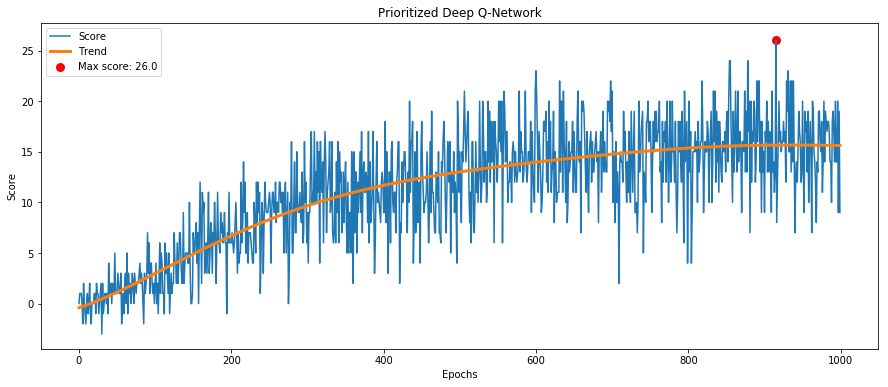

In [9]:
plot_scores(scores, 'Prioritized Deep Q-Network', polyfit_deg=6)

In [ ]:
# agent.load_weights('double_local_weights.pth')

### 5. DQN using Noisy Networks for Exploration

One fundamental problem of Reinforcement Learning: is Exploration/Exploitation dilemma. This issue raises from the fact that our agent needs to keep the balance between exploring the environment and using what's learned from this exploration. There are different ways to address this problem. Most common one is using epsilon-greedy: with some probability epsilon (given as hyperparameter) your agent takes a random step instead of acting according to policy it has learned.

DeepMind proposes very simple and surprisingly efficient way of tackling the above issue. The method basically consists of adding the gaussian noise to the last (fully-connected) layers of the network.

Read more about the technique in this [blog post](https://medium.com/@shmuma/summary-noisy-networks-for-exploration-c8ba6e2759c7)

In [7]:
agent = DQNAgent(env.state_size, env.action_size, use_noise=True)
agent.summary()

DQNAgent:

Using Double: False
Using Dueling: False
Using Priority: False
Using Noise: True

QNetwork(
  (fc1): Linear(in_features=37, out_features=32, bias=True)
  (fc2): NoisyLinear(in_features=32, out_features=64, bias=True)
  (fc3): NoisyLinear(in_features=64, out_features=128, bias=True)
  (fc4): NoisyLinear(in_features=128, out_features=4, bias=True)
)


In [8]:
scores = agent.train(env)

Episode 100	Average Score: 1.53
* Best score so far: 1.53. Saving the weights

Episode 200	Average Score: 7.70
* Best score so far: 7.7. Saving the weights

Episode 300	Average Score: 11.78
* Best score so far: 11.78. Saving the weights

Episode 400	Average Score: 12.50
* Best score so far: 12.5. Saving the weights

Episode 500	Average Score: 13.59
* Best score so far: 13.59. Saving the weights

Episode 600	Average Score: 14.31
* Best score so far: 14.31. Saving the weights

Episode 700	Average Score: 15.91
* Best score so far: 15.91. Saving the weights

Episode 800	Average Score: 16.78
* Best score so far: 16.78. Saving the weights

Episode 900	Average Score: 17.10
* Best score so far: 17.1. Saving the weights

Episode 1000	Average Score: 17.00


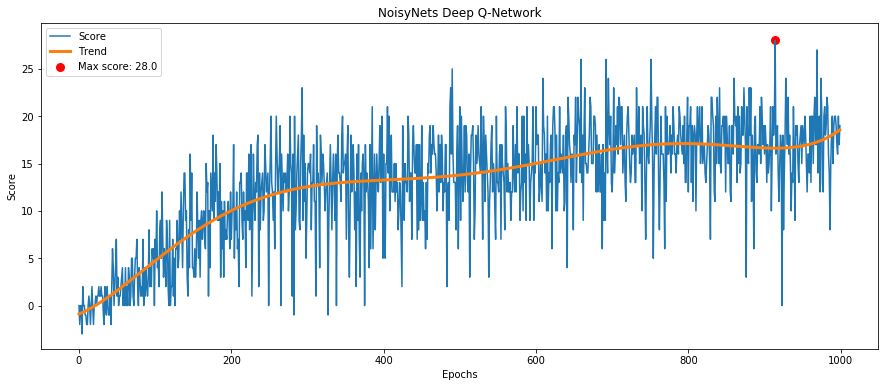

In [9]:
plot_scores(scores, 'NoisyNets Deep Q-Network', polyfit_deg=6)

In [7]:
# agent.load_weights('noisy_local_weights.pth')

### 6. Using Double, Dueling, PER and NoisyNets at once

Let's see what it is to use all this improvements at the same time 😉

In [6]:
agent = DQNAgent(env.state_size, 
                 env.action_size, 
                 use_double=True, 
                 use_dueling=True, 
                 use_priority=True, 
                 use_noise=True)
agent.summary()

DQNAgent:

Using Double: True
Using Dueling: True
Using Priority: True
Using Noise: True

DuelingQNetwork(
  (features): Sequential(
    (0): Linear(in_features=37, out_features=32, bias=True)
    (1): ReLU()
    (2): NoisyLinear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): NoisyLinear(in_features=64, out_features=128, bias=True)
  )
  (advantage): Sequential(
    (0): NoisyLinear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): NoisyLinear(in_features=256, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): NoisyLinear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): NoisyLinear(in_features=256, out_features=1, bias=True)
  )
)


In [7]:
scores = agent.train(env)

Episode 100	Average Score: 6.58
* Best score so far: 6.58. Saving the weights

Episode 200	Average Score: 10.54
* Best score so far: 10.54. Saving the weights

Episode 300	Average Score: 11.00
* Best score so far: 11.0. Saving the weights

Episode 400	Average Score: 13.16
* Best score so far: 13.16. Saving the weights

Episode 500	Average Score: 14.75
* Best score so far: 14.75. Saving the weights

Episode 600	Average Score: 15.73
* Best score so far: 15.73. Saving the weights

Episode 700	Average Score: 15.19
Episode 800	Average Score: 15.71
Episode 900	Average Score: 15.99
* Best score so far: 15.99. Saving the weights

Episode 1000	Average Score: 17.04
* Best score so far: 17.04. Saving the weights



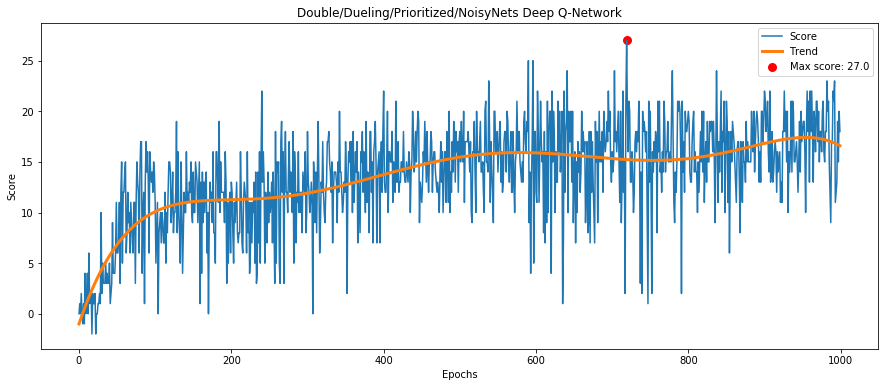

In [8]:
plot_scores(scores, 'Double/Dueling/Prioritized/NoisyNets Deep Q-Network', polyfit_deg=6)